In [9]:
from IPython.display import clear_output
import SALib
clear_output()
print("Everything A-Okay!")

Everything A-Okay!


In [10]:
%matplotlib inline
# LIN: dont use?
from SALib.sample import saltelli

# # LIN: our traffic?
# from model import Traffic
# # LIN: Peds, cars, lights
# from agent import Pedestrian, Car

import os

from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Create the parameter sets to check

In [11]:
# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 5
distinct_samples = 10
bounds = [
          [120, 220], # vision_angle, smaller?
          [2,30], #N, smaller?
          [2,6],# vision range in meters
          [.1, 1.5]]

# We define our variables and bounds
problem = {
    'num_vars': len(bounds),
    'names': ["vision_angle", "N", "vision_range",
        "Ek_w"],
    'bounds': bounds
}
problem

# indices of the integers
ints = [1]
print('integers:')
for i in ints:
    print(problem['names'][i])

# Create the sample set
param_values = saltelli.sample(problem, distinct_samples)
print('\nnum samples', len(param_values))
print('num sims', len(param_values)*replicates)
print('num params', len(param_values[0]))

integers:
N

num samples 100
num sims 500
num params 4


In [12]:
for vals in param_values:
    param_dict = {}
    for i in range(len(problem['names'])):
        if problem['names'][i] == "N":
            param_dict[problem['names'][i]] = int(vals[i])
        else:
            param_dict[problem['names'][i]] = vals[i]
    print(param_dict)

{'vision_angle': 141.97265625, 'N': 4, 'vision_range': 4.07421875, 'Ek_w': 1.0474609375}
{'vision_angle': 148.02734375, 'N': 4, 'vision_range': 4.07421875, 'Ek_w': 1.0474609375}
{'vision_angle': 141.97265625, 'N': 27, 'vision_range': 4.07421875, 'Ek_w': 1.0474609375}
{'vision_angle': 141.97265625, 'N': 4, 'vision_range': 2.18359375, 'Ek_w': 1.0474609375}
{'vision_angle': 141.97265625, 'N': 4, 'vision_range': 4.07421875, 'Ek_w': 1.3591796875}
{'vision_angle': 141.97265625, 'N': 27, 'vision_range': 2.18359375, 'Ek_w': 1.3591796875}
{'vision_angle': 148.02734375, 'N': 4, 'vision_range': 2.18359375, 'Ek_w': 1.3591796875}
{'vision_angle': 148.02734375, 'N': 27, 'vision_range': 4.07421875, 'Ek_w': 1.3591796875}
{'vision_angle': 148.02734375, 'N': 27, 'vision_range': 2.18359375, 'Ek_w': 1.0474609375}
{'vision_angle': 148.02734375, 'N': 27, 'vision_range': 2.18359375, 'Ek_w': 1.3591796875}
{'vision_angle': 191.97265625, 'N': 18, 'vision_range': 2.07421875, 'Ek_w': 0.34746093749999996}
{'vision

In [13]:
for vals in param_values:
    param_dict = {}
    for i in range(len(problem['names'])):
        param_dict[problem['names'][i]] = vals[i]
    print(param_dict)
# problem

{'vision_angle': 141.97265625, 'N': 4.70703125, 'vision_range': 4.07421875, 'Ek_w': 1.0474609375}
{'vision_angle': 148.02734375, 'N': 4.70703125, 'vision_range': 4.07421875, 'Ek_w': 1.0474609375}
{'vision_angle': 141.97265625, 'N': 27.40234375, 'vision_range': 4.07421875, 'Ek_w': 1.0474609375}
{'vision_angle': 141.97265625, 'N': 4.70703125, 'vision_range': 2.18359375, 'Ek_w': 1.0474609375}
{'vision_angle': 141.97265625, 'N': 4.70703125, 'vision_range': 4.07421875, 'Ek_w': 1.3591796875}
{'vision_angle': 141.97265625, 'N': 27.40234375, 'vision_range': 2.18359375, 'Ek_w': 1.3591796875}
{'vision_angle': 148.02734375, 'N': 4.70703125, 'vision_range': 2.18359375, 'Ek_w': 1.3591796875}
{'vision_angle': 148.02734375, 'N': 27.40234375, 'vision_range': 4.07421875, 'Ek_w': 1.3591796875}
{'vision_angle': 148.02734375, 'N': 27.40234375, 'vision_range': 2.18359375, 'Ek_w': 1.0474609375}
{'vision_angle': 148.02734375, 'N': 27.40234375, 'vision_range': 2.18359375, 'Ek_w': 1.3591796875}
{'vision_angle'

In [14]:
parma

NameError: name 'parma' is not defined

In [15]:
a = [1,2,3]
if 3 in a:
    print(2)

2


Create file
### ADD/change the data headers from wolf/sheep to new things

In [16]:
import csv
import random
import datetime

# Set headers for the datafile
# TODO: add data headers
headers = ["run"] + problem["names"] + ["wolf", "sheep"]
output_file_name = "try_SA" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + ".csv"
# If file does not yet exist, write columnheaders first 
with open(output_file_name, "w") as f:
    writer = csv.writer(f)
    writer.writerow(headers)
headers

['run', 'vision_angle', 'N', 'vision_range', 'Ek_w', 'wolf', 'sheep']

In [17]:
directory = os.fsencode("data")

# make a list of lists with histogram information
peds_hists = []
cars_hists = []

if directory:

    for file in os.listdir(directory):
        filename = os.fsdecode(file)

        if filename.startswith("SA"):
            df = pd.read_csv("data/" + filename, header=4)
            print(df)

In [18]:

count = 0
# Replicating the experiments
for i in range(replicates):
    # Vals is one sample with values for each of the parameters
    for vals in param_values: 
        # Change parameters that should be integers
        vals = list(vals)
        for i in ints:
            vals[i] = int(vals[i])

        # TODO: add parameter for SA count
#         Run model with these parameters
#         model = Traffic()
            # 
#         model.set_parameters()
#         model.run_model(steps, results)
        
        # RETURN DATA
        data = [random.uniform(10, 2), random.uniform(10, 2)]
        
        # Add data to dataframe
        # TODO: add data
        values_row = [count] + vals + data
        # Write values_row
        with open(output_file_name, "a") as f:
            writer = csv.writer(f)
            writer.writerow(values_row)
        
        count += 1
        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')
    


100.00% done


In [19]:
data = pd.read_csv("try_SA2019-01-31_18-26-38.csv")
data

,run,vision_angle,N,vision_range,Ek_w,Ok_w,Pk_w,Ak_w,Ik_w,speed_mean,...,gamma,max_density,crossing_mean,crossing_sd,max_peds,max_cars,spawn_rate_car,spawn_rate_pedes,wolf,sheep
0,0,141.972656,3,4.074219,1.176758,0.324219,0.825781,0.136719,0.819531,0.130059,...,0.816992,4.764648,0.228906,0.126758,17,4,0.144226,0.069601,9.427520,9.934182
1,1,219.121094,3,4.074219,1.176758,0.324219,0.825781,0.136719,0.819531,0.130059,...,0.816992,4.764648,0.228906,0.126758,17,4,0.144226,0.069601,9.946536,8.826138
2,2,141.972656,15,4.074219,1.176758,0.324219,0.825781,0.136719,0.819531,0.130059,...,0.816992,4.764648,0.228906,0.126758,17,4,0.144226,0.069601,2.209337,5.654308
3,3,141.972656,3,4.089844,1.176758,0.324219,0.825781,0.136719,0.819531,0.130059,...,0.816992,4.764648,0.228906,0.126758,17,4,0.144226,0.069601,9.786525,5.997266
4,4,141.972656,3,4.074219,1.049805,0.324219,0.825781,0.136719,0.819531,0.130059,...,0.816992,4.764648,0.228906,0.126758,17,4,0.144226,0.069601,2.654282,3.476609
5,5,141.972656,3,4.074219,1.176758,0.860156,0.825781,0.136719,0.819531,0.130059,...,0.816992,4.764648,0.228906,0.126758,17,4,0.144226,0.069601,9.693593,9.532619
6,6,141.972656,3,4.074219,1.176758,0.324219,0.532031,0.136719,0.819531,0.130059,...,0.816992,4.764648,0.228906,0.126758,17,4,0.144226,0.069601,9.435507,2.653180
7,7,141.972656,3,4.074219,1.176758,0.324219,0.825781,0.566406,0.819531,0.130059,...,0.816992,4.764648,0.228906,0.126758,17,4,0.144226,0.069601,4.354520,9.245658
8,8,141.972656,3,4.074219,1.176758,0.324219,0.825781,0.136719,0.825781,0.130059,...,0.816992,4.764648,0.228906,0.126758,17,4,0.144226,0.069601,5.405779,9.218743
9,9,141.972656,3,4.074219,1.176758,0.324219,0.825781,0.136719,0.819531,0.102402,...,0.816992,4.764648,0.228906,0.126758,17,4,0.144226,0.069601,5.060186,7.210055


# Analysis


In [20]:
data_names = ["sheep", "wolf"]

In [21]:
Si_one = sobol.analyze(problem, data[data_names[0]].as_matrix(), print_to_console=False)
Si_two = sobol.analyze(problem, data[data_names[1]].as_matrix(), print_to_console=False)
Si_one

C:\Users\linda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\linda\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


{'S1': array([-0.07342121, -0.15129778, -0.13021817, -0.11960142]),
 'S1_conf': array([0.20798994, 0.20363958, 0.21667525, 0.21296581]),
 'S2': array([[       nan, 0.16844406, 0.14880852, 0.10514746],
        [       nan,        nan, 0.17167974, 0.23298145],
        [       nan,        nan,        nan, 0.0430174 ],
        [       nan,        nan,        nan,        nan]]),
 'S2_conf': array([[       nan, 0.26784191, 0.26887678, 0.27313311],
        [       nan,        nan, 0.26081194, 0.26705621],
        [       nan,        nan,        nan, 0.27901252],
        [       nan,        nan,        nan,        nan]]),
 'ST': array([0.88230847, 0.90436528, 0.83719853, 0.89394988]),
 'ST_conf': array([0.1675577 , 0.17505025, 0.14304532, 0.15085155])}

This is not very insightfull. Let's make a function that can plot this.

In [14]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
        
    Code from assignments of course Agent-based modelling, january 2019
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

We'll first plot 1st, 2nd, and total-order sensitivity for the output variable 'Sheep', then for 'Wolves'. 

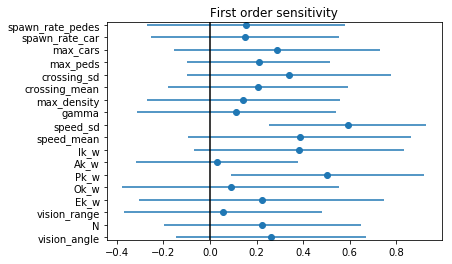

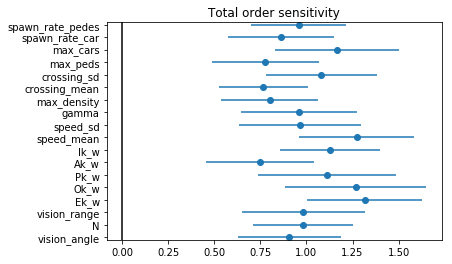

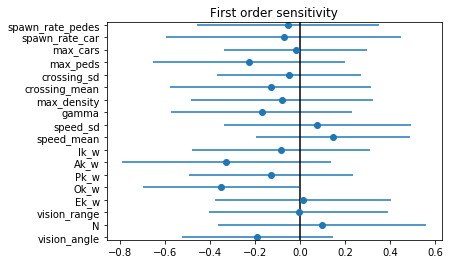

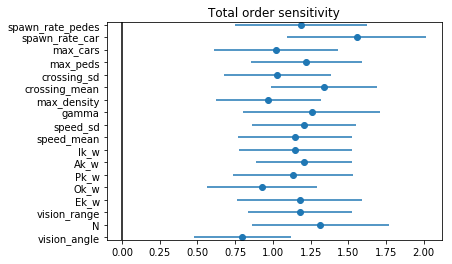

In [15]:
for Si in (Si_one, Si_two):
    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

#     # Second order
#     plot_index(Si, problem['names'], '2', 'Second order sensitivity')
#     plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()


In [49]:
def things(aa, bb, cc):
    print(aa, bb, cc)
    print(bb)

        
aaa = {'bb':2, 'cc':6, 'aa':3, }
things(**aaa)

3 2 6
2


In [28]:
param_values[0]

array([1.41972656e+02, 4.70703125e+00, 4.07421875e+00, 1.04746094e+00,
       4.92382812e-01, 1.37011719e+00, 1.64257812e-01, 1.35917969e+00,
       1.30058594e-01, 3.06933594e-02, 9.18945312e-01, 4.76464844e+00,
       2.96679688e-01, 1.26757813e-01, 1.71777344e+01, 3.59082031e+00,
       3.62666016e-02, 6.96005859e-02, 2.97451172e-01, 1.03535156e+00])